In [1]:
import numpy as np
import pandas as pd
import glob
import os

import matplotlib.pylab as plt
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Gradient flow through targets of canned losses in torch.nn module

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable

BATCH_SIZE = 16

criterion_mse = nn.MSELoss()
x = Variable(torch.FloatTensor( BATCH_SIZE , 10  )  )
l = nn.Linear( 10 , 10 )
y = l(x)
loss = criterion_mse( y, x )

#### Loading large csv file with pandas

In [3]:
import pandas as pd
import csv, sys

csv.field_size_limit(sys.maxsize)

131072

In [ ]:
cities_df = pd.read_csv("/home/data/world-cities/cities_over_10kpop.csv", engine='python')

In [ ]:
cities_df.head()

#### Splitting files of a directory into train, valid, test splits

In [ ]:
files = glob.glob("/home/data/world-cities/spatial-maps/samples/*")
files_df = pd.DataFrame(map(lambda f: (f,) + os.path.splitext(os.path.basename(f)), 
                 files), columns=["filename", "sample", "ext"])
files_df['sample'] = files_df['sample'].apply(lambda x: x.replace(".pickle", ""))
files_df.set_index("sample", inplace=True)
sample_names = files_df.index.unique().values
frac_train = 0.8
frac_valid = frac_test = 0.1
len_splits = [int(frac_train*len(sample_names)), int((frac_train+frac_valid)*len(sample_names))]
np.random.shuffle(sample_names)
train_idx, valid_idx, test_idx = np.split(sample_names, len_splits)


In [ ]:
train_idx.shape, valid_idx.shape, test_idx.shape

In [ ]:
train_files = files_df.loc[train_idx]['filename'].values
valid_files = files_df.loc[valid_idx]['filename'].values
test_files  = files_df.loc[test_idx]['filename'].values


In [ ]:
len(train_files), len(valid_files), len(test_files)

#### Operations on images

In [4]:
from PIL import Image
from scipy.ndimage.interpolation import rotate

img = np.random.random((3,3,4))
print img.shape

img_rot = rotate(img, 10, reshape=False)
print img_rot.shape

# Image.fromarray(img)

(3, 3, 4)
(3, 3, 4)


In [5]:
img_rot.min(), img.min()

(0.0, 0.016158141327495712)

In [6]:
img_rot

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.11818155,  0.07328958,  0.72581187,  0.22048538],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.8629785 ,  0.10816022,  1.02808428,  0.57006607],
        [ 0.80511924,  0.522182  ,  0.57820267,  0.88983767],
        [ 0.14611579,  0.48307099,  0.49976233,  0.07077062]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.70339474,  0.78881927,  0.4752827 ,  0.2944849 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])

In [7]:
img

array([[[ 0.71273009,  0.28769977,  0.78122466,  0.23158882],
        [ 0.12063694,  0.01615814,  0.83717287,  0.09085291],
        [ 0.41601928,  0.4960141 ,  0.14899909,  0.9301559 ]],

       [[ 0.83513937,  0.15353544,  0.97652022,  0.61395324],
        [ 0.80511924,  0.522182  ,  0.57820267,  0.88983767],
        [ 0.17804383,  0.48221717,  0.54313793,  0.09830719]],

       [[ 0.28954008,  0.92025773,  0.02364681,  0.38368753],
        [ 0.72200586,  0.73627119,  0.5198482 ,  0.28495403],
        [ 0.11206874,  0.49383311,  0.0790061 ,  0.37058427]]])

#### Testing loader for DataFolder 

In [8]:
import sys
sys.path.append("/home/nbserver/BEGAN-pytorch/")
import data_loader as dl
reload(dl)
from datafolder import basic_preprocess, default_loader, flip_ndimage, rotate_ndimage
from utils import save_image_channels

from skimage.io import imread

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
loader = dl.get_loader("/home/data/CelebA", "train", 8, 128)
loader = iter(loader)

Loading data from /home/data/CelebA/splits/train 
Found 162770 images in subfolders of: /home/data/CelebA/splits/train


torch.Size([8, 3, 128, 128])


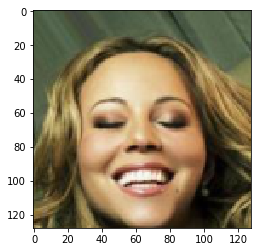

In [10]:
dat, _ = next(loader)
print dat.shape
plt.imshow(dat.numpy()[0].transpose((1,2,0)))

In [43]:
normalize_channels = ([0, 160.91, 1.295, 0, 0],
                      [1, 1010.413, 15.326, 1, 1])
normalize = True
take_log = True #[1,2]
rotate_angle = 0
res_scale = 64

loader = dl.get_loader("/home/data/world-cities/spatial-maps/", "train", 
                       8, res_scale, 
                       load_attributes=["region", "profiles"], 
                       rotate_angle=rotate_angle, 
                       normalize=normalize, 
                       take_log=take_log)
loader = iter(loader)

Loading data from /home/data/world-cities/spatial-maps/splits/train log scale
Found 26865 images in subfolders of: /home/data/world-cities/spatial-maps/splits/train


Mean [ 0.107       0.33700001  0.212       0.889       0.15700001]
Stdv [ 0.27900001  0.368       0.30000001  0.30599999  0.36199999]
Min  [ 0.  0.  0.  0.  0.]
Max  [ 1.  1.  1.  1.  1.]
albania_lezh_kurbinit_very-small_43534_41.6269_19.7135
direct: ['0.0000-1.0000', '0.0000-24220.0000', '0.0000-124.4849', '0.0000-1.0000', '0.0000-1.0000']
torch : ['0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000']
prepr: ['0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000', '0.0000-1.0000']


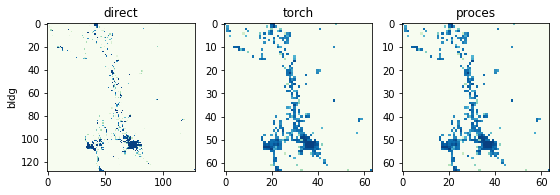

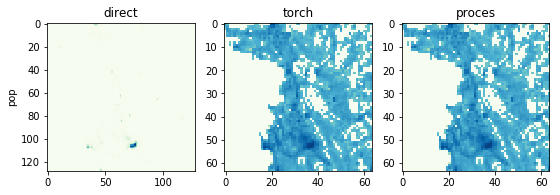

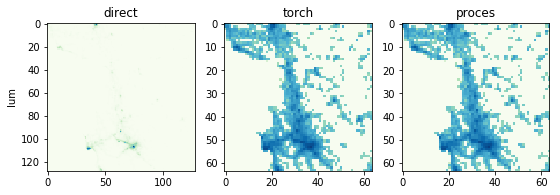

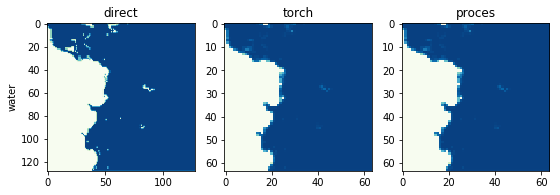

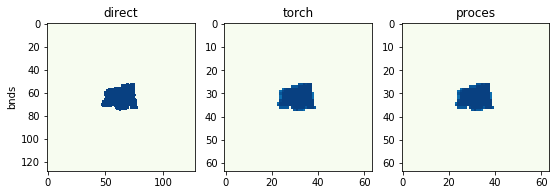

In [44]:
dat, atr, names = next(loader)

mu_smpl = dat.numpy().mean((0,2,3))
sd_smpl = dat.numpy().std((0,2,3))
max_smpl= dat.numpy().max((0,2,3))
min_smpl= dat.numpy().min((0,2,3))

print "Mean", np.round(mu_smpl, 3)
print "Stdv", np.round(sd_smpl, 3)
print "Min ", np.round(min_smpl, 3)
print "Max ", np.round(max_smpl, 3)

i = 0

# data processed through torchvision
img = dat[i].numpy()

# data read directly
img_path = "/home/data/world-cities/spatial-maps/splits/train/%s.tif" % names[i]
img0 = imread(img_path)
img1 = basic_preprocess(img0.copy(), res_scale, 
                        normalize=normalize, log=take_log)

print names[i]
print "direct:", ["%2.4f-%2.4f"%x for x in zip(img0.min((0,1)), img0.max((0,1)))]
print "torch :", ["%2.4f-%2.4f"%x for x in zip(img.min((1,2)), img.max((1,2)))]
print "prepr:", ["%2.4f-%2.4f"%x for x in zip(img1.min((0,1)), img1.max((0,1)))]

prc = ["direct", "torch", "proces"]
src = ["bldg", "pop", "lum", "water", "bnds"]

for i,r in enumerate(src):
    fig, ax = plt.subplots(1,3, figsize=(9,6))
    ax[0].imshow(img0[...,i], cmap=cm.GnBu); ax[0].set_ylabel(r)
    ax[1].imshow(img[i,...], cmap=cm.GnBu);
    ax[2].imshow(img1[...,i], cmap=cm.GnBu)
    for a,s in zip(ax,prc):
        # a.axis("off")
        a.set_title(s)

In [46]:
scale = float(reduce(lambda x, y: x * y, [l for l in dat.size()], 1))
dat.norm(1)/scale

0.3404428199680865

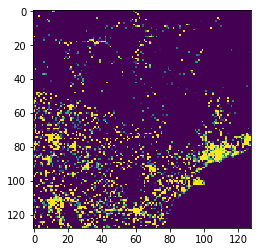

In [13]:
plt.imshow(img0[...,0])

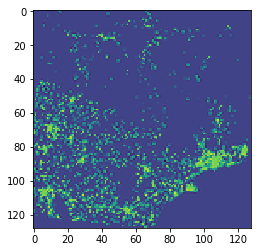

In [16]:
plt.imshow(rotate_ndimage(np.expand_dims(img0[...,0], 2))[...,0])

In [17]:
img0_rot = rotate_ndimage(img0)
img0_rot.min((0,1)), img0_rot.max((0,1))

(array([ 0.,  0.,  0.,  0.,  0.]),
 array([  1.00000000e+00,   1.54510000e+04,   6.15202191e+01,
          1.00000000e+00,   1.00000000e+00]))

In [18]:
img0.min((0,1)), img0.max((0,1))

(array([ 0.,  0.,  0.,  0.,  0.]),
 array([  1.00000000e+00,   1.54510000e+04,   6.15202191e+01,
          1.00000000e+00,   1.00000000e+00]))

In [22]:
dat.shape

torch.Size([8, 5, 64, 64])

In [23]:
torch.sum(torch.abs(dat), 1).shape

torch.Size([8, 64, 64])

In [24]:
torch.mean(torch.abs(dat[:,1,...]))

100.27593567090662

In [25]:
torch.mean(torch.sum(torch.abs(dat[:,1,...]), 1))

6417.65990652889

In [ ]:
# identify images with no data on relevant channels and remove them
mean_channels = dat.numpy().mean((2,3))

idx_rm = []
for i in range(mean_channels.shape[1]-1):
    print "Channel %d:"%i, (mean_channels[:,i]==0).sum()
    idx_rm += np.where((mean_channels[:,i]==0))[0].tolist()
    
# for i in idx_rm:
#     f1 = "/home/data/world-cities/spatial-maps/splits/train/%s.tif"%names[i]
#     f2 = "/home/data/world-cities/spatial-maps/splits/train/%s.pickle.gz"%names[i]
#     os.remove(f1)
#     os.remove(f2)

# Channel 0: 3
# Channel 1: 1
# Channel 2: 16
# Channel 3: 0

#### Flip ndimage (equivalent of the flip functionality in torchvision but for numpy arrays istead of PIL images)

In [ ]:
A = np.arange(12).reshape((2,2,3))
print A
flip_ndimage(A)

#### Display/save ndimage by channel

In [ ]:
plt.figure(figsize=(16,6))
ndarr = save_image_channels(dat, #filename="./bla.png", 
                            ncol=8, padding=3, take_log=[1,2],
                            scale_each=False, normalize=True,
                   channel_names=["bldg", 'pop', 'lum', 'water', 'bounds'],
                   sample_names=["S%d"%i for i in range(10)])

#### Torchvision Lambda Transformations

In [ ]:
from torchvision import transforms
import torch
from datafolder import basic_preprocess, default_loader, flip_ndimage, rotate_ndimage

In [ ]:
img_path = "/home/data/world-cities/spatial-maps/splits/train/%s.tif" % names[4]
img0 = imread(img_path)

In [ ]:
transf_list = []
use_channels = [0]
transf_list+=[transforms.Lambda(lambda img: img[...,use_channels])]
transf_list += [transforms.Lambda(lambda img: basic_preprocess(img,res_scale, log=take_log, normalize=normalize))]
transf_list += [transforms.Lambda(lambda img: flip_ndimage(img,0)), 
                transforms.Lambda(lambda img: flip_ndimage(img,1))]
transf_list += [transforms.Lambda(lambda img: rotate_ndimage(img,rotate_angle))]
transf_list += [transforms.Lambda(lambda img: torch.from_numpy(img.transpose((2,0,1))).float())]
transform = transforms.Compose(transf_list)


In [ ]:
timg0 = transform(img0)
plt.imshow(timg0.numpy().squeeze(), cmap=cm.gray_r)

#### Compute radial profiles

In [ ]:
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City


In [ ]:
cities = []
for i in range(8):
    M = dat[i,:3].numpy().transpose((1,2,0))
    water = dat[i,3].numpy() == 0
    bounds = dat[i,4].numpy()
    cities += [City(M, name="S%d"%i, 
                    mask=None, bounds=bounds, 
                    sources=["built", "pop", "lum"])]    
    
colormap = {"built":"black", "pop":"green", "lum":"orange", "all":"blue"}
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# using radial estimation method
sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(1,8, figsize=(16,2), 
                       gridspec_kw={"wspace":0.03, "hspace":0.25},
                       sharex=True, sharey=True)


for i,city in enumerate(cities):
    profiles = city.compute_profile(method="radial", step=2, scale=False)

    L = len(profiles.values()[0][0])
    xlabels = np.arange(L) * 0.75 * 4

    for c,p in profiles.iteritems():
        s = np.nanmax(p[0])
        s = 1 if s == 0 else s
        ax[i].plot(xlabels, p[0] / s, label=c, lw=2, color=colormap[c])
    # ax[i].legend(loc="best")
    ax[i].set_xlabel("$d \ [km]$")

In [ ]:
plt.imshow(dat[1,1].numpy())

In [ ]:
p

In [ ]:
fig, ax = plt.subplots(dat.size()[:2][::-1])
ax = ax.flatten()

for i in range(dat.size()[0]):
    for c in range(dat.size()[1]):
        plt.imshow(dat.numpy()[i,...].transpose((1,2,0))